<a href="https://colab.research.google.com/github/jnielsonresearch/Machine-Learning-Templates/blob/master/Classification_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification ML Models

## Importing the libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [3]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas.util.testing as tm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


In [4]:
# Plotting configuration for Jupyter notebook
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Importing the dataset

In [5]:
# Download the data
import os
datapath = os.path.join("Data", "")

files = ['playoff_boxscores.csv', 'team_box_hustle.csv']
  
# Download the data
import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/jnielsonresearch/crunch-time-analytics/main/Hustle%20Stats%20Research/"
os.makedirs(datapath, exist_ok=True)
for filename in files:
    print("Downloading", filename)
    url = DOWNLOAD_ROOT + "Data/" + filename
    urllib.request.urlretrieve(url, datapath + filename)

playoff_boxscores = pd.read_csv(datapath + files[0])
team_box_hustle = pd.read_csv(datapath + files[1])

In [6]:
playoff_boxscores.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,SEASON
0,42019,1610612738,BOS,Boston Celtics,41900306,2020-09-27,BOS @ MIA,L,240,113,43,99,0.434,15,46,0.326,12,15,0.800,13,29,42,26,7,2,10,21,-12.0,2019-20
1,42019,1610612738,BOS,Boston Celtics,41900305,2020-09-25,BOS vs. MIA,W,238,121,42,93,0.452,12,38,0.316,25,29,0.862,13,37,50,29,7,4,11,23,13.0,2019-20
2,42019,1610612738,BOS,Boston Celtics,41900304,2020-09-23,BOS @ MIA,L,239,109,39,82,0.476,14,40,0.350,17,21,0.810,12,34,46,28,3,5,19,24,0.2,2019-20
3,42019,1610612738,BOS,Boston Celtics,41900303,2020-09-19,BOS @ MIA,W,240,117,41,85,0.482,9,26,0.346,26,30,0.867,10,40,50,27,8,3,14,29,8.4,2019-20
4,42019,1610612738,BOS,Boston Celtics,41900302,2020-09-17,BOS vs. MIA,L,240,101,36,72,0.500,10,28,0.357,19,24,0.792,6,35,41,19,5,3,20,22,-5.0,2019-20


In [7]:
team_box_hustle.head()

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MINUTES,PTS,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,BOX_OUTS
0,41600171,1610612762,Jazz,UTA,Utah,240.000000:00,97,67,44,23,15,0,10,21,0,0,8,0,0,0,0,0
1,41600171,1610612746,Clippers,LAC,LA,240.000000:00,95,60,50,10,10,0,7,14,0,0,8,0,0,0,0,0
2,41600203,1610612738,Celtics,BOS,Boston,240.000000:00,89,68,48,20,19,0,8,18,0,0,8,0,0,0,0,0
3,41600203,1610612764,Wizards,WAS,Washington,240.000000:00,116,61,35,26,19,0,12,27,0,0,12,0,0,0,0,0
4,41500135,1610612738,Celtics,BOS,Boston,240.000000:00,83,54,37,17,9,0,3,6,0,0,1,0,0,0,0,0


In [8]:
# Drop duplicate columns in team_box_hustle dataset 
cols = ['GAME_ID', 'TEAM_ID','CONTESTED_SHOTS', 'CONTESTED_SHOTS_2PT',
       'CONTESTED_SHOTS_3PT', 'DEFLECTIONS', 'CHARGES_DRAWN', 'SCREEN_ASSISTS',
       'SCREEN_AST_PTS', 'OFF_LOOSE_BALLS_RECOVERED',
       'DEF_LOOSE_BALLS_RECOVERED', 'LOOSE_BALLS_RECOVERED', 'OFF_BOXOUTS',
       'DEF_BOXOUTS', 'BOX_OUT_PLAYER_TEAM_REBS', 'BOX_OUT_PLAYER_REBS',
       'BOX_OUTS']
team_box_hustle = team_box_hustle[cols]

In [9]:
# Merge playoff_boxscores and team_box_hustle datasets on GAME_ID
hustle_stats = playoff_boxscores.merge(team_box_hustle, how='inner', on=['GAME_ID', 'TEAM_ID'])

In [10]:
hustle_stats.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'SEASON',
       'CONTESTED_SHOTS', 'CONTESTED_SHOTS_2PT', 'CONTESTED_SHOTS_3PT',
       'DEFLECTIONS', 'CHARGES_DRAWN', 'SCREEN_ASSISTS', 'SCREEN_AST_PTS',
       'OFF_LOOSE_BALLS_RECOVERED', 'DEF_LOOSE_BALLS_RECOVERED',
       'LOOSE_BALLS_RECOVERED', 'OFF_BOXOUTS', 'DEF_BOXOUTS',
       'BOX_OUT_PLAYER_TEAM_REBS', 'BOX_OUT_PLAYER_REBS', 'BOX_OUTS'],
      dtype='object')

In [11]:
hustle_stats.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,SEASON,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,BOX_OUTS
0,42019,1610612738,BOS,Boston Celtics,41900306,2020-09-27,BOS @ MIA,L,240,113,43,99,0.434,15,46,0.326,12,15,0.800,13,29,42,26,7,2,10,21,-12.0,2019-20,58,38,20,19,0,6,14,2,4,6,5,6,8,4,11
1,42019,1610612738,BOS,Boston Celtics,41900305,2020-09-25,BOS vs. MIA,W,238,121,42,93,0.452,12,38,0.316,25,29,0.862,13,37,50,29,7,4,11,23,13.0,2019-20,52,24,28,14,0,9,23,2,3,5,4,8,11,7,12
2,42019,1610612738,BOS,Boston Celtics,41900304,2020-09-23,BOS @ MIA,L,239,109,39,82,0.476,14,40,0.350,17,21,0.810,12,34,46,28,3,5,19,24,0.2,2019-20,58,37,21,11,0,4,10,2,2,4,3,16,13,6,19
3,42019,1610612738,BOS,Boston Celtics,41900303,2020-09-19,BOS @ MIA,W,240,117,41,85,0.482,9,26,0.346,26,30,0.867,10,40,50,27,8,3,14,29,8.4,2019-20,58,23,35,11,0,4,9,3,4,7,2,11,8,2,13
4,42019,1610612738,BOS,Boston Celtics,41900302,2020-09-17,BOS vs. MIA,L,240,101,36,72,0.500,10,28,0.357,19,24,0.792,6,35,41,19,5,3,20,22,-5.0,2019-20,56,24,32,11,0,11,24,7,2,9,2,8,6,2,10


In [12]:
# Create calculated metric NBA composite "Hustle Rating":
# Formula source: https://grantland.com/the-triangle/how-do-you-measure-hustle-in-the-nba-theres-a-stat-for-that/

# 2-Point Field Goal Contested: A contest decreases the probability of a 2-Point Field Goal going in by .05 x 2.0 Point Value of a 2-Point Field Goal = .1 Hustle Points.

# 3-Point Field Goal Contested: A contest decreases the probability of a 3-Point Field Goal going in by .05 x 3.0 Point Value of a 3-Point Field Goal = .15 Hustle Points.

# Deflection: We estimate that the team whose player deflected the ball has a .25 chance of recovering the ball x 1.0 Expected Point Value for gaining possession = .25 Hustle Points.

# Loose-Ball Recovered: Recovering a loose ball increases the probability of possession by .5 x 1.0 Expected Point Value for gaining possession = .5 Hustle Points.

# Charge: 1.5 Expected Point Value for creating a turnover when the opponent otherwise would have likely taken a very good shot (as most charges take place near the basket) + .25 Expected Point Value by drawing a foul on the opposing player (gets team closer to the bonus and limits opposing player’s ability to play) = 1.75 Hustle Points.

hustle_stats['HUSTLE_RATING'] = hustle_stats.apply(lambda x: x['CONTESTED_SHOTS_2PT']*0.1 + x['CONTESTED_SHOTS_3PT']*0.15 + x['DEFLECTIONS']*0.25 + x['LOOSE_BALLS_RECOVERED']*0.5 + x['CHARGES_DRAWN']*1.5, axis=1)

In [13]:
hustle_stats.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,SEASON,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,BOX_OUTS,HUSTLE_RATING
0,42019,1610612738,BOS,Boston Celtics,41900306,2020-09-27,BOS @ MIA,L,240,113,43,99,0.434,15,46,0.326,12,15,0.800,13,29,42,26,7,2,10,21,-12.0,2019-20,58,38,20,19,0,6,14,2,4,6,5,6,8,4,11,14.55
1,42019,1610612738,BOS,Boston Celtics,41900305,2020-09-25,BOS vs. MIA,W,238,121,42,93,0.452,12,38,0.316,25,29,0.862,13,37,50,29,7,4,11,23,13.0,2019-20,52,24,28,14,0,9,23,2,3,5,4,8,11,7,12,12.60
2,42019,1610612738,BOS,Boston Celtics,41900304,2020-09-23,BOS @ MIA,L,239,109,39,82,0.476,14,40,0.350,17,21,0.810,12,34,46,28,3,5,19,24,0.2,2019-20,58,37,21,11,0,4,10,2,2,4,3,16,13,6,19,11.60
3,42019,1610612738,BOS,Boston Celtics,41900303,2020-09-19,BOS @ MIA,W,240,117,41,85,0.482,9,26,0.346,26,30,0.867,10,40,50,27,8,3,14,29,8.4,2019-20,58,23,35,11,0,4,9,3,4,7,2,11,8,2,13,13.80
4,42019,1610612738,BOS,Boston Celtics,41900302,2020-09-17,BOS vs. MIA,L,240,101,36,72,0.500,10,28,0.357,19,24,0.792,6,35,41,19,5,3,20,22,-5.0,2019-20,56,24,32,11,0,11,24,7,2,9,2,8,6,2,10,14.45


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


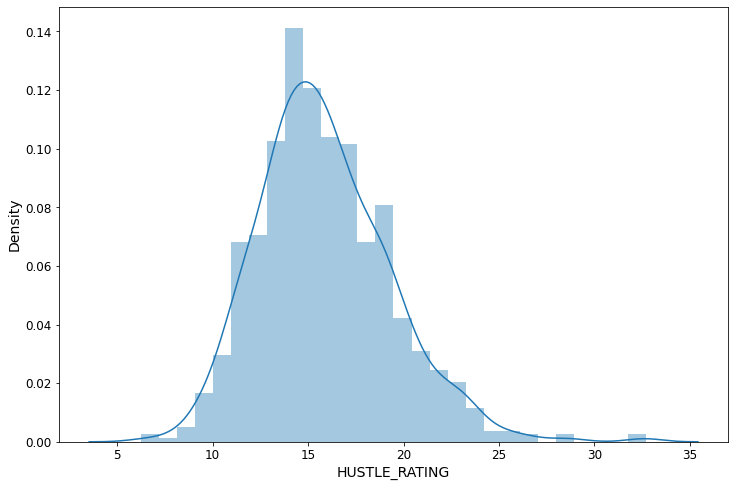

In [14]:
# Distribution plot of hustle_rating
plt.figure(figsize=(12,8))
sns.distplot(hustle_stats['HUSTLE_RATING'])

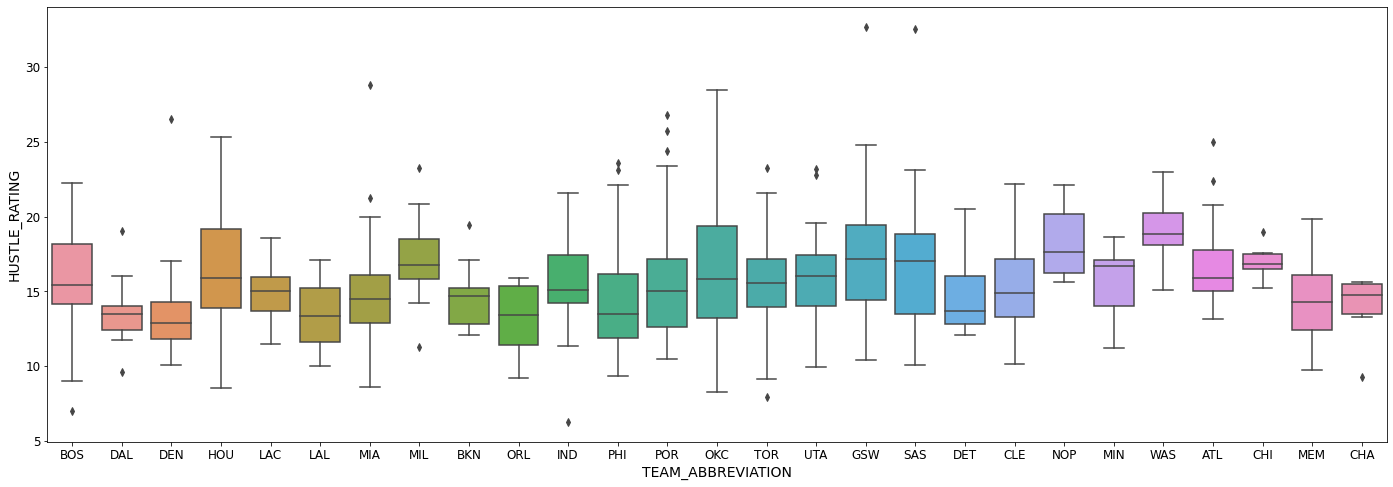

In [15]:
# HUSTLE_RATING BY TEAM
plt.figure(figsize=(24,8))
sns.boxplot(data=hustle_stats, x='TEAM_ABBREVIATION', y='HUSTLE_RATING')

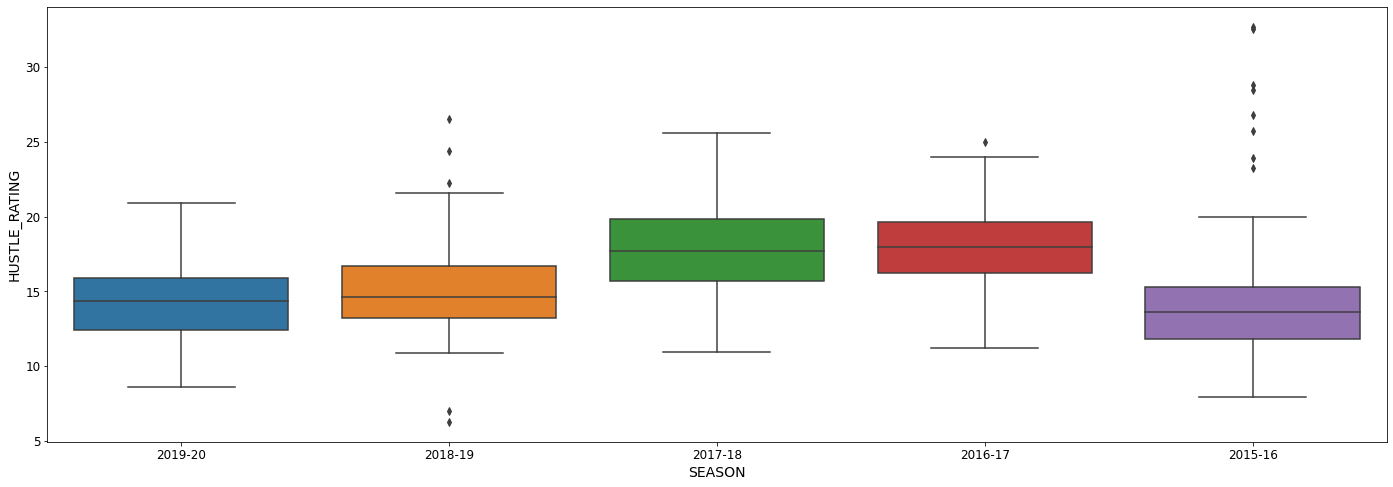

In [16]:
# HUSTLE_RATING BY SEASON
plt.figure(figsize=(24,8))
sns.boxplot(data=hustle_stats, x='SEASON', y='HUSTLE_RATING')

## Correlation Pairplot for Select Team Hustle Stats and Win-Loss Record

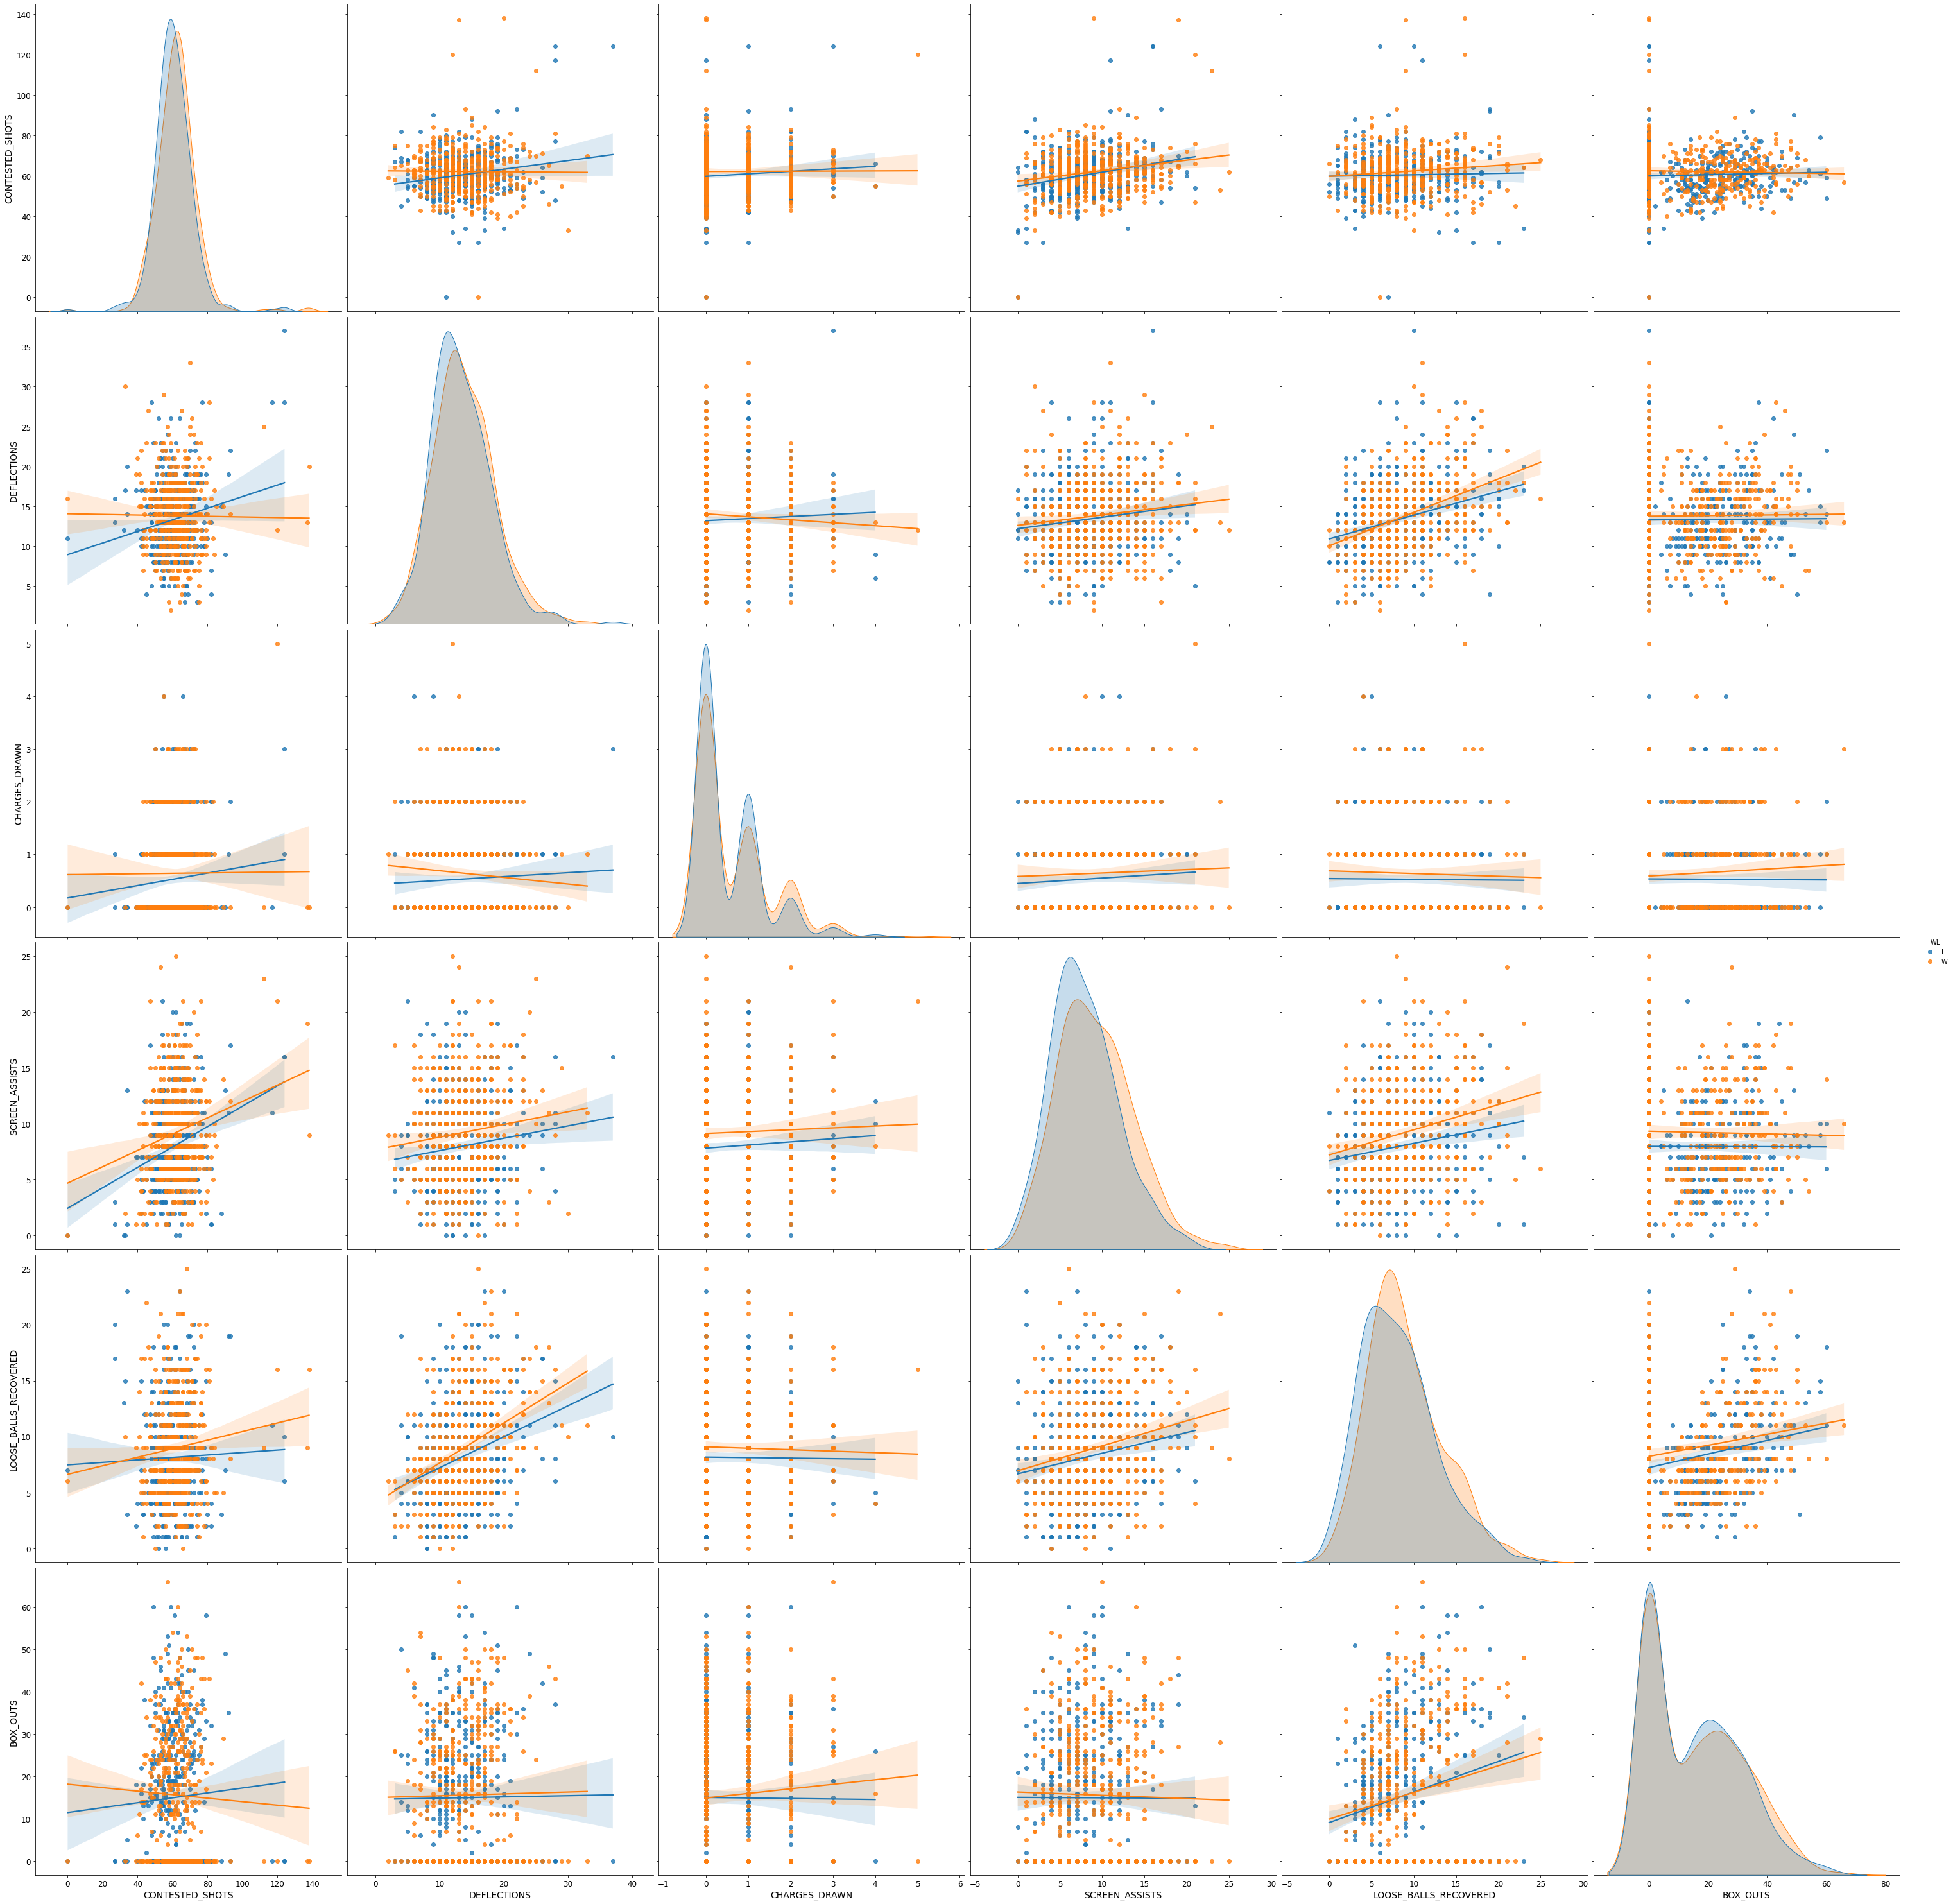

In [17]:
# Pairplot with WL

dataset = hustle_stats[['CONTESTED_SHOTS', 'DEFLECTIONS', 'CHARGES_DRAWN', 'SCREEN_ASSISTS',
       'LOOSE_BALLS_RECOVERED','BOX_OUTS','WL']]

sns.pairplot(dataset, height=7, kind='reg', hue='WL')

## Scaling and Train Test Split of Dataset

In [18]:
# hustle stats features for classification model
X = hustle_stats[['CONTESTED_SHOTS', 'CONTESTED_SHOTS_2PT', 'CONTESTED_SHOTS_3PT',
       'DEFLECTIONS', 'CHARGES_DRAWN', 'SCREEN_ASSISTS', 'SCREEN_AST_PTS',
       'OFF_LOOSE_BALLS_RECOVERED', 'DEF_LOOSE_BALLS_RECOVERED',
       'LOOSE_BALLS_RECOVERED', 'OFF_BOXOUTS', 'DEF_BOXOUTS',
       'BOX_OUT_PLAYER_TEAM_REBS', 'BOX_OUT_PLAYER_REBS', 'BOX_OUTS', 'HUSTLE_RATING']].values

# encode class values WL as integers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = hustle_stats['WL']
encoder.fit(y)
y = encoder.transform(y)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression Model on Training and Test sets

Logistic Regression Model:
               precision    recall  f1-score   support

     class 0       0.64      0.65      0.64        83
     class 1       0.64      0.62      0.63        82

    accuracy                           0.64       165
   macro avg       0.64      0.64      0.64       165
weighted avg       0.64      0.64      0.64       165

Confusion Matrix:
 [[54 29]
 [31 51]]

Average Cross Validation Score:  0.59

Average Precision-Recall Score: 0.58


Text(0.5, 1.0, '2-class Precision-Recall Curve: AP=0.58')

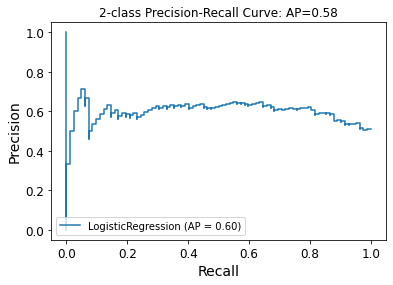

In [21]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 1234)
classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Classification report
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print("Logistic Regression Model:\n", classification_report(y_test, y_test_pred, target_names=target_names))

# Confusion matrix and accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n",cm)

# Average Cross Validation Score
from sklearn.model_selection import cross_val_score
cv = cross_val_score(classifier, X_train, y_train, cv=10, scoring="accuracy")
print("\nAverage Cross Validation Score: ", round(np.mean(cv),2))

# Average Precision Score and Precision-Recall curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_test_pred)
print('\nAverage Precision-Recall Score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall Curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Schochastic Gradient Decent Classifier Model

Schochastic Gradient Decent Classifier Model:
               precision    recall  f1-score   support

     class 0       0.47      0.46      0.47        83
     class 1       0.47      0.49      0.48        82

    accuracy                           0.47       165
   macro avg       0.47      0.47      0.47       165
weighted avg       0.47      0.47      0.47       165

Confusion Matrix:
 [[38 45]
 [42 40]]

Average Cross Validation Score:  0.55

Average Precision-Recall Score: 0.48


Text(0.5, 1.0, '\n2-class Precision-Recall Curve: AP=0.48')

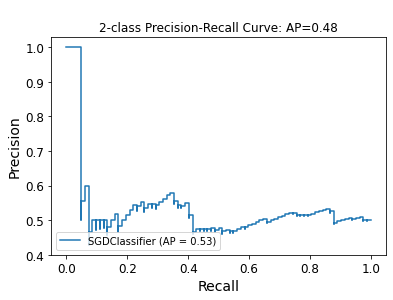

In [22]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(max_iter=1000, tol=1e-3, random_state=1234)
classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Classification report
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print("Schochastic Gradient Decent Classifier Model:\n", classification_report(y_test, y_test_pred, target_names=target_names))

# Confusion matrix and accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n",cm)

# Average Cross Validation Score
from sklearn.model_selection import cross_val_score
cv = cross_val_score(classifier, X_train, y_train, cv=10, scoring="accuracy")
print("\nAverage Cross Validation Score: ", round(np.mean(cv),2))

# Average Precision Score and Precision-Recall curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_test_pred)
print('\nAverage Precision-Recall Score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('\n2-class Precision-Recall Curve: '
                   'AP={0:0.2f}'.format(average_precision))



## KNN Classification Model

KNeighborsClassifier Model:
               precision    recall  f1-score   support

     class 0       0.49      0.57      0.53        83
     class 1       0.49      0.41      0.45        82

    accuracy                           0.49       165
   macro avg       0.49      0.49      0.49       165
weighted avg       0.49      0.49      0.49       165

Confusion Matrix:
 [[47 36]
 [48 34]]

Average Cross Validation Score:  0.51

Average Precision-Recall Score: 0.49


Text(0.5, 1.0, '2-class Precision-Recall Curve: AP=0.49')

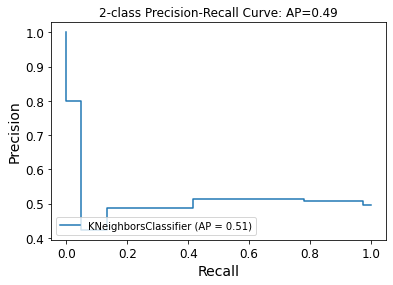

In [23]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Classification report
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print("KNeighborsClassifier Model:\n", classification_report(y_test, y_test_pred, target_names=target_names))

# Confusion matrix and accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n",cm)

# Average Cross Validation Score
from sklearn.model_selection import cross_val_score
cv = cross_val_score(classifier, X_train, y_train, cv=10, scoring="accuracy")
print("\nAverage Cross Validation Score: ", round(np.mean(cv),2))

# Average Precision Score and Precision-Recall curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_test_pred)
print('\nAverage Precision-Recall Score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall Curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Support Vector Machine Classification Model

Support Vector Machine Classification Model:
               precision    recall  f1-score   support

     class 0       0.61      0.65      0.63        83
     class 1       0.62      0.59      0.60        82

    accuracy                           0.62       165
   macro avg       0.62      0.62      0.62       165
weighted avg       0.62      0.62      0.62       165

Confusion Matrix:
 [[54 29]
 [34 48]]

Average Cross Validation Score:  0.56

Average Precision-Recall Score: 0.57


Text(0.5, 1.0, '2-class Precision-Recall Curve: AP=0.57')

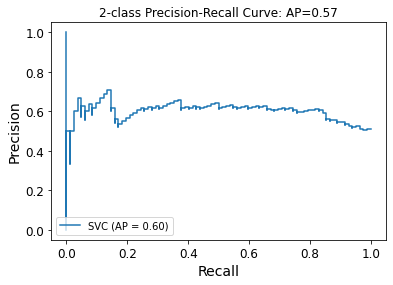

In [24]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 1234)
classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Classification report
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print("Support Vector Machine Classification Model:\n", classification_report(y_test, y_test_pred, target_names=target_names))

# Confusion matrix and accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n",cm)

# Average Cross Validation Score
from sklearn.model_selection import cross_val_score
cv = cross_val_score(classifier, X_train, y_train, cv=10, scoring="accuracy")
print("\nAverage Cross Validation Score: ", round(np.mean(cv),2))

# Average Precision Score and Precision-Recall curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_test_pred)
print('\nAverage Precision-Recall Score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall Curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Naive Bayes Classification Model

Naive Bayes Classification Model:
               precision    recall  f1-score   support

     class 0       0.53      0.66      0.59        83
     class 1       0.55      0.41      0.47        82

    accuracy                           0.54       165
   macro avg       0.54      0.54      0.53       165
weighted avg       0.54      0.54      0.53       165

Confusion Matrix:
 [[55 28]
 [48 34]]

Average Cross Validation Score:  0.55

Average Precision-Recall Score: 0.52


Text(0.5, 1.0, '2-class Precision-Recall Curve: AP=0.52')

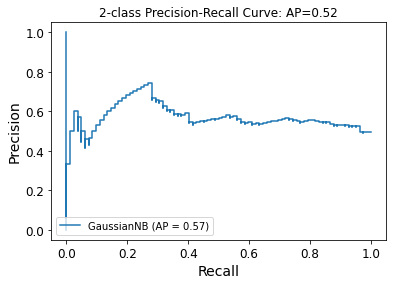

In [25]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Classification report
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print("Naive Bayes Classification Model:\n", classification_report(y_test, y_test_pred, target_names=target_names))

# Confusion matrix and accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n",cm)

# Average Cross Validation Score
from sklearn.model_selection import cross_val_score
cv = cross_val_score(classifier, X_train, y_train, cv=10, scoring="accuracy")
print("\nAverage Cross Validation Score: ", round(np.mean(cv),2))

# Average Precision Score and Precision-Recall curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_test_pred)
print('\nAverage Precision-Recall Score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall Curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Random Forest Classification Model

Random Forest Classification Model:
               precision    recall  f1-score   support

     class 0       0.60      0.61      0.61        83
     class 1       0.60      0.59      0.59        82

    accuracy                           0.60       165
   macro avg       0.60      0.60      0.60       165
weighted avg       0.60      0.60      0.60       165

Confusion Matrix:
 [[51 32]
 [34 48]]

Average Cross Validation Score:  0.54

Average Precision-Recall Score: 0.56


Text(0.5, 1.0, '2-class Precision-Recall Curve: AP=0.56')

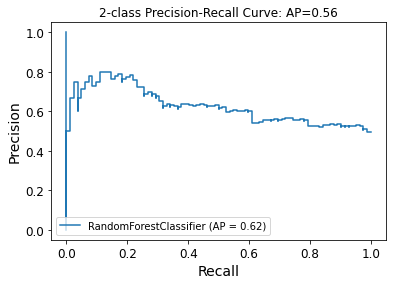

In [26]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 1234)
classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Classification report
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print("Random Forest Classification Model:\n", classification_report(y_test, y_test_pred, target_names=target_names))

# Confusion matrix and accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n",cm)

# Average Cross Validation Score
from sklearn.model_selection import cross_val_score
cv = cross_val_score(classifier, X_train, y_train, cv=10, scoring="accuracy")
print("\nAverage Cross Validation Score: ", round(np.mean(cv),2))

# Average Precision Score and Precision-Recall curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_test_pred)
print('\nAverage Precision-Recall Score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall Curve: '
                   'AP={0:0.2f}'.format(average_precision))